# 2.0 Neural Network Training and Image Classification

This notebook will run you through the following:

*   Loading in downloaded optical data as well as label file created from previous notebook
*   Prepping the data to be read into the Neural Network (NN)
*   Splitting the data into training, validation, and testing data for the NN
*   Constructing, training and running the NN on test data

If you haven't done so already, make sure Google Drive is mounted to this notebook by clicking on the folder icon located in the vertical toolbar on the left side of the screen and then clicking on the folder icon with the Google Drive symbol on it.




## 2.1 Setup

In the following cells, we will install and import the packages we're planning to use for this notebook. These include pyrsgis which is for working with raster data, and scikit-learn and tensorflow which are used for NN construction and prep.

In [1]:
#Install Packages

!pip install pyrsgis
!pip install scikit-learn
!pip install tensorflow

In [2]:
#Import Modules

from osgeo import gdal
from pyrsgis import raster
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## 2.2 Prepare Training Data

We will now read in the different bands (in this case bands 2-7 for Landsat 8) for the optical acquisition we've chosen as our training image.

**Note: when choosing a training image for snow cover, you might have to view the land cover file to see what season it shows and pick an acquisition from that season. For example, the NLCD shows perennial snow, which at a place like Mt. St. Helens means long lasting snow that is present even in the summer/early fall months. That is why the example training image is from September 13, 2016.**

In [3]:
#Read in Training Data

B2_train = gdal.Open('/content/drive/MyDrive/NOTEBOOK_TEST_FOLDER/MSH_SR_B2_2016-09-13.tif')
B3_train = gdal.Open('/content/drive/MyDrive/NOTEBOOK_TEST_FOLDER/MSH_SR_B3_2016-09-13.tif')
B4_train = gdal.Open('/content/drive/MyDrive/NOTEBOOK_TEST_FOLDER/MSH_SR_B4_2016-09-13.tif')
B5_train = gdal.Open('/content/drive/MyDrive/NOTEBOOK_TEST_FOLDER/MSH_SR_B5_2016-09-13.tif')
B6_train = gdal.Open('/content/drive/MyDrive/NOTEBOOK_TEST_FOLDER/MSH_SR_B6_2016-09-13.tif')
B7_train = gdal.Open('/content/drive/MyDrive/NOTEBOOK_TEST_FOLDER/MSH_SR_B7_2016-09-13.tif')

In [4]:
#Read in Label File

label_file = gdal.Open('/content/drive/MyDrive/LandCover_CROP/snow_label.tif')

We will then convert the rasters of optical band data and the label file to two dimensional arrays.

In [5]:
#Convert Raster to Array

B2_vals = B2_train.GetRasterBand(1)
band_2 = B2_vals.ReadAsArray()

B3_vals = B3_train.GetRasterBand(1)
band_3 = B3_vals.ReadAsArray()

B4_vals = B4_train.GetRasterBand(1)
band_4 = B4_vals.ReadAsArray()

B5_vals = B5_train.GetRasterBand(1)
band_5 = B5_vals.ReadAsArray()

B6_vals = B6_train.GetRasterBand(1)
band_6 = B6_vals.ReadAsArray()

B7_vals = B7_train.GetRasterBand(1)
band_7 = B7_vals.ReadAsArray()

In [6]:
label_vals = label_file.GetRasterBand(1)
label_band = label_vals.ReadAsArray()

To read in to the neural network, the band data must be converted to a one dimensional matrix with each band stacked as layers. We use the ravel() command to produce 1D arrays of each band and the label file. Then we combine all of these arrays together.

In [7]:
band_2_1d = band_2.ravel()
band_3_1d = band_3.ravel()
band_4_1d = band_4.ravel()
band_5_1d = band_5.ravel()
band_6_1d = band_6.ravel()
band_7_1d = band_7.ravel()

In [8]:
label_1d = label_band.ravel()

In [9]:
#Combine Arrays and Normalize for NN Read In

combined_vals = np.array([band_2_1d,band_3_1d,band_4_1d,band_5_1d,band_6_1d,band_7_1d])
index_vals = np.swapaxes(combined_vals, 0, 1)

When you run the below cell, the first output should show two dimensions, the first indicating how many pixels are in one band of your training image (the length x width) and the second indicating how many bands you're using (in the example case it should read 6). The second output should be one value that matches the number of pixels from the first output.

In [10]:
print(index_vals.shape)
print(label_1d.shape)

(3775536, 6)
(3775536,)


We then normalize the training data and the label file by the maximum values their file format can take.

In [11]:
index_vals_normed = index_vals / 65455.0  #65455.0 is the maximum value Landsat 8 Surface Reflectance Bands can measure
label_1d_normed = label_1d / 255.0        #255 is the maximum value produced by saving the label file as a raster

## 2.3 Split Training Data into Model Training and Model Testing Data

This marks the beginning of decisions we can make when constructing our neural network. We must first choose how we want to split the available pixels in our chosen training image between pixels used for training the neural network and pixels used for testing the neural network's accuracy.

In [12]:
TS = 0.2    # percentage of data that will be used for testing the Neural Network, can be any decimal between 0 and 1
RS = 42     # random state that the model starts on as decided by integer value

We will use the train_test_split command from sklearn to split our data based off our chosen percentage.

In [13]:
xTrain, xTest, yTrain, yTest = train_test_split(index_vals_normed, label_1d_normed, test_size=TS, random_state=RS)

After splitting our data, our xTrain and yTrain should have the same amount of pixels (xTrain having six bands' worth and yTrain having one because it is for the label file). Similarly, xTest and yTest should have the same amount of pixels.

In [14]:
print(xTrain.shape)
print(yTrain.shape)

(2265321, 6)
(2265321,)


In [15]:
print(xTest.shape)
print(yTest.shape)

(1510215, 6)
(1510215,)


In [16]:
xTrain = xTrain.reshape((xTrain.shape[0],1,xTrain.shape[1]))
xTest = xTest.reshape((xTest.shape[0],1,xTest.shape[1]))

print(xTrain.shape, xTest.shape)

(2265321, 1, 6) (1510215, 1, 6)


## 2.4 Set Up and Train the Neural Network

We will now set up the neural network to use for image classification. There are a variety of choices that can be made when constructing the NN. We will touch on some of them here, but there will be additional resources to explore further options.

First we will import keras (a Python API for interfacing with artificial neural networks) from tensorflow. To learn more about keras, click here: https://keras.io/api/

In [17]:
from tensorflow import keras

For the neural network model, we will need to set up the following:
1.   The input layer that reads in data
2.   The hidden layer
3.   The output layer that produces the classified snow cover data

For the hidden and output layer, we have to decide which activation function we want to use. Put very simply, the role of an activation function is to produce output from a set of input values fed to a node or a layer.

There are a variety of activation functions to choose from in keras: https://keras.io/api/layers/activations/

For the example setup in this notebook, the hidden layer will have an activation function of ReLU and the output layer will have a softmax activation function.

In [18]:
hidden_act = 'relu'     # ReLU is a fast and reliable activation function that decreases computing time
output_act = 'softmax'  # Softmax is often used as the last layer in classification b/c its outputs are probability values

We also need to choose how many nodes will make up each layer. For the output layer, we will select two, one that will say the probability of snow cover in a pixel and one that will say the probability of no snow cover in a pixel. For the hidden layer, this requires more fine tuning, as there is no set number of nodes a hidden layer has to have. Rather, it is better to test different quantities of nodes and see which number minimizes the loss. There will be more on this later, but for now the first guess at number of nodes for the hidden layer can be input.

In [19]:
hidden_nodes = 20
output_nodes = 2

We also need to choose the optimizer and the loss function for the neural network. Optimizers help change weights between nodes to help the neural network train, while the loss function measures how well the neural network models the training data.

To see the optimizers keras has available click here:
https://keras.io/api/optimizers/

To see the loss functions keras has available click here:
https://keras.io/api/losses/


In [20]:
OPT = "adam"
LOSS_F = "sparse_categorical_crossentropy"

We will then choose the number of epochs (iterations through the training data) as well as the split of training data between training and validation. These are also different values that can be changed to minimize error of the model.

In [21]:
EPOCH_NUM = 3     # input is an integer
VAL_SPLIT = 0.2   # input is a decimal between 0 and 1, this is the percentage

We then set up the model and run the training.

In [42]:
#Set Up Model

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, 6)),
    keras.layers.Dense(hidden_nodes, activation=hidden_act),
    keras.layers.Dense(output_nodes, activation=output_act)])

model.compile(optimizer=OPT, loss=LOSS_F,metrics=["accuracy"])

hist = model.fit(xTrain,yTrain,epochs=EPOCH_NUM,validation_split=VAL_SPLIT)

Epoch 1/3
56633/56633 [==============================] - 106s 2ms/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 7.0137e-04 - val_accuracy: 0.9998
Epoch 2/3
56633/56633 [==============================] - 105s 2ms/step - loss: 8.2769e-04 - accuracy: 0.9998 - val_loss: 6.9563e-04 - val_accuracy: 0.9998
Epoch 3/3
56633/56633 [==============================] - 109s 2ms/step - loss: 8.1821e-04 - accuracy: 0.9998 - val_loss: 6.8576e-04 - val_accuracy: 0.9998


## 2.4.1 Visualize Loss/Accuracy from Neural Network (Optional)

To help determine if we need more or less epochs for our neural network, we can uncomment the follow commands and plot the loss of the model compared with the validation data loss. There should be a point at which the loss stabilizes which can indicate how many epochs we need, or if there is no stabilization then that could indicate more epochs are needed.

In [28]:
with open('Training_Hist','wb') as file:
  pickle.dump(hist.history, file)

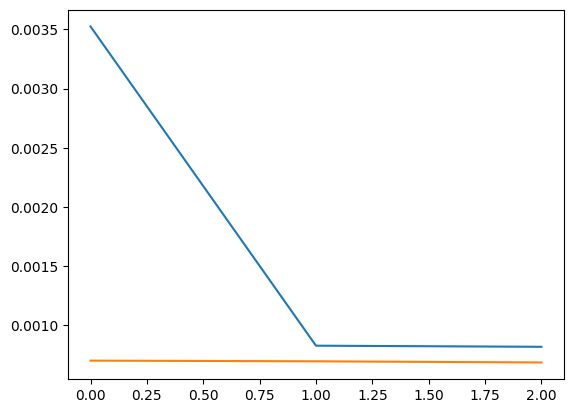

In [43]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

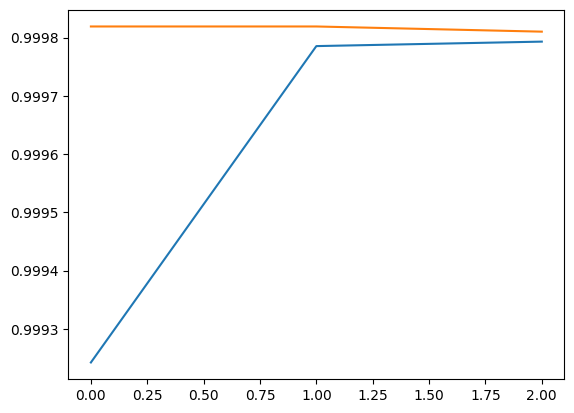

In [44]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

## 2.4.2 Save and/or Load Model (Optional)

If we want to save the model to load for future use, we can run the following command. This will save the model in the folder we set up in the previous notebook where our data and label file are stored.

In [64]:
#model.save('/content/drive/MyDrive/NOTEBOOK_TEST_FOLDER/NN_classify.keras')  #uncomment to run command

If we are returning to this notebook and want to load an already trained and saved model, we can run the following command. This will load the model saved in our selected folder from the previous command.

In [19]:
#model = keras.models.load_model('/content/drive/MyDrive/NOTEBOOK_TEST_FOLDER/NN_classify.keras')   #uncomment to run command

## 2.5 Run the Neural Network Model on the Test Data ##

We are now ready to run the model on the test data from the selected training image and analyze how well the model performs on data that is already classified.

In [20]:
#Run Neural Network on Test Data

from sklearn.metrics import confusion_matrix, precision_score, recall_score

yTestPredicted = model.predict(xTest)
yTestPredicted = yTestPredicted[:,1]

47195/47195 [==============================] - 79s 2ms/step


To test how well the model classified the test data, we can view the confusion matrix as well as the p-score and the r-score. The confusion matrix tells us how many pixels were correctly identified and how many were incorrectly identified, while the p-score and r-score indicate the utility of the model in terms of how well it correctly identified pixels.

In [21]:
threshold = 0.8   # this can be altered depending on prediction value of interest

In [22]:
yTestPredicted = (yTestPredicted>threshold).astype(int)
cMatrix = confusion_matrix(yTest, yTestPredicted)
pScore = precision_score(yTest,yTestPredicted)
rScore = recall_score(yTest,yTestPredicted)

print("Confusion matrix: for 20 nodes\n", cMatrix)
print("\nP-Score: %.3f, R-Score: %.3f" % (pScore, rScore))

Confusion matrix: for 20 nodes
 [[1509823      30]
 [    251     111]]

P-Score: 0.787, R-Score: 0.307


## 2.6 Read in Data to Classify with Trained Neural Network

Similar to our training image, we will do the following steps for the optical image we wish to classify snow cover for:

*   Read in image band data
*   Convert raster image band data to arrays
*   Make arrays of image band data one-dimensional
*   Stack 1D arrays together
*   Normalize pixel values in 1D stacked array

In [31]:
# Read in Test Data for NN

B2_test = gdal.Open('/content/drive/MyDrive/NOTEBOOK_TEST_FOLDER/MSH_SR_B2_2014-08-07.tif')
B3_test = gdal.Open('/content/drive/MyDrive/NOTEBOOK_TEST_FOLDER/MSH_SR_B3_2014-08-07.tif')
B4_test = gdal.Open('/content/drive/MyDrive/NOTEBOOK_TEST_FOLDER/MSH_SR_B4_2014-08-07.tif')
B5_test = gdal.Open('/content/drive/MyDrive/NOTEBOOK_TEST_FOLDER/MSH_SR_B5_2014-08-07.tif')
B6_test = gdal.Open('/content/drive/MyDrive/NOTEBOOK_TEST_FOLDER/MSH_SR_B6_2014-08-07.tif')
B7_test = gdal.Open('/content/drive/MyDrive/NOTEBOOK_TEST_FOLDER/MSH_SR_B7_2014-08-07.tif')

# Convert Raster Data to Array

B2_tvals = B2_test.GetRasterBand(1)
B2_tband = B2_tvals.ReadAsArray()

B3_tvals = B3_test.GetRasterBand(1)
B3_tband = B3_tvals.ReadAsArray()

B4_tvals = B4_test.GetRasterBand(1)
B4_tband = B4_tvals.ReadAsArray()

B5_tvals = B5_test.GetRasterBand(1)
B5_tband = B5_tvals.ReadAsArray()

B6_tvals = B6_test.GetRasterBand(1)
B6_tband = B6_tvals.ReadAsArray()

B7_tvals = B7_test.GetRasterBand(1)
B7_tband = B7_tvals.ReadAsArray()

# Make Band Array Data 1D

B2_1d_test = B2_tband.ravel()
B3_1d_test = B3_tband.ravel()
B4_1d_test = B4_tband.ravel()
B5_1d_test = B5_tband.ravel()
B6_1d_test = B6_tband.ravel()
B7_1d_test = B7_tband.ravel()

# Stack 1D Arrays Together

combined_test_vals = np.array([B2_1d_test, B3_1d_test, B4_1d_test, B5_1d_test, B6_1d_test, B7_1d_test])
index_test_vals = np.swapaxes(combined_test_vals, 0, 1)

# Normalize Stacked Array Values

index_test_vals = index_test_vals.reshape((index_test_vals.shape[0],1,index_test_vals.shape[1]))
index_test_vals_normed = index_test_vals / 65455.0

## 2.7 Run Neural Network Model on New Data

We are now ready to run the model on new data to classify it for snow cover.

In [32]:
predicted = model.predict(index_test_vals_normed)
predicted = predicted[:,1]

117986/117986 [==============================] - 187s 2ms/step


The last two cells below will shape the prediction to the dimensions of the original raster data and output a raster file with a name of our choosing.

In [33]:
prediction = np.reshape(predicted, (B2_test.RasterYSize, B2_test.RasterXSize))

In [34]:
outFile = '/content/drive/MyDrive/NOTEBOOK_TEST_FOLDER/Prediction_Test0201_Snow_20140807.tif'
raster.export(prediction, B2_test, filename=outFile, dtype='float')